**Imports**: Importing necessary PyTorch libraries for building neural networks and tensor operations.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

**Input Tensor**: Creating a random input tensor `x` representing a batch of sequences.
- `batch_size`: Number of sequences in the batch (here, 1).
- `sequence_length`: Length of each sequence (here, 4).
- `input_dim`: Dimensionality of the input features (here, 512).
- The size of `x` is (batch_size, sequence_length, input_dim).

In [ ]:
sequence_length = 4 #my name is Wahb
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn((batch_size, sequence_length, input_dim))

**Input Tensor Size**: Displaying the size of the input tensor `x`.
- Size: (1, 4, 512)

In [ ]:
x.size()

torch.Size([1, 4, 512])

**Linear Layer for QKV**: Creating a linear layer to project the input features into Query (Q), Key (K), and Value (V) vectors.
- `input_dim`: Input feature dimension (512).
- `3 * d_model`: Output dimension, which is 3 times the model dimension (`d_model`) to accommodate Q, K, and V for multi-head attention. Here, it's 3 * 512 = 1536.

In [ ]:
qkv_linear = nn.Linear(input_dim, 3*d_model)

**Applying Linear Layer**: Applying the linear layer `qkv_linear` to the input tensor `x`.
- The linear layer transforms the last dimension of `x` from `input_dim` (512) to `3 * d_model` (1536).

In [ ]:
qkv = qkv_linear(x)

**QKV Tensor Size**: Displaying the size of the resulting tensor `qkv`.
- Size: (batch_size, sequence_length, 3 * d_model). Here, it's (1, 4, 1536). This tensor contains the concatenated Q, K, and V for all attention heads.

In [ ]:
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

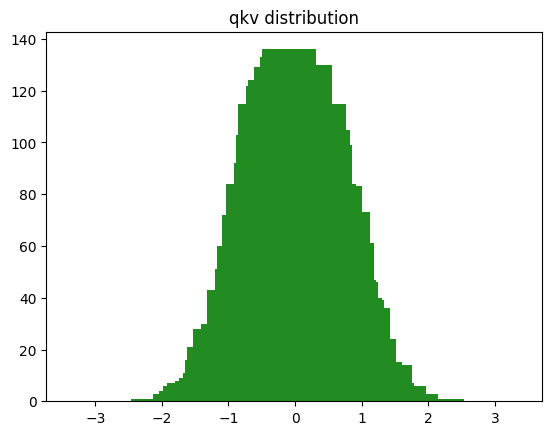

In [ ]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [ ]:
num_heads = 8
head_dim = d_model // num_heads
print(head_dim)
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)
qkv = qkv.permute(0, 2, 1, 3)

64


In [ ]:
qkv.shape

torch.Size([1, 8, 4, 192])

**Q, K, V Tensor Shapes**: The `q`, `k`, and `v` tensors each have a shape of `(1, 8, 4, 64)`.
- **1**: Batch size.
- **8**: Number of attention heads.
- **4**: Sequence length.
- **64**: Head dimension (`d_model / num_heads`).

In [ ]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

In [ ]:
d_k = q.shape[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [ ]:
k.T.shape

torch.Size([64, 4, 8, 1])

In [ ]:
k.transpose(-1, -2).shape

torch.Size([1, 8, 64, 4])

In [ ]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [ ]:
(scaled + mask)[0][0]

tensor([[ 0.1114,    -inf,    -inf,    -inf],
        [ 0.2192,  0.1304,    -inf,    -inf],
        [ 0.3629, -0.0562,  0.1760,    -inf],
        [-0.2850, -0.0551, -0.0084, -0.0667]], grad_fn=<SelectBackward0>)

In [ ]:
scaled += mask

In [ ]:
attention = f.softmax(scaled, dim=-1)
attention.shape

torch.Size([1, 8, 4, 4])

In [ ]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5222, 0.4778, 0.0000, 0.0000],
        [0.4021, 0.2644, 0.3335, 0.0000],
        [0.2074, 0.2610, 0.2735, 0.2580]], grad_fn=<SelectBackward0>)

In [ ]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

In [ ]:
import math

def scaled_dot_product_attention(query, key, value, mask = None):
    d_k = query.size()[-1]
    scaled = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
      scaled += mask
    attention = f.softmax(scaled, dim=-1)
    values = torch.matmul(attention, value)
    return values, attention

In [ ]:
values, attention = scaled_dot_product_attention(q, k, v, mask=mask)

In [ ]:
attention.shape

torch.Size([1, 8, 4, 4])

In [ ]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5222, 0.4778, 0.0000, 0.0000],
        [0.4021, 0.2644, 0.3335, 0.0000],
        [0.2074, 0.2610, 0.2735, 0.2580]], grad_fn=<SelectBackward0>)

In [ ]:
values.size()
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [ ]:
linear_layer = nn.Linear(d_model, d_model)

In [ ]:
out = linear_layer(values)


In [ ]:
out.shape


torch.Size([1, 4, 512])

In [ ]:
out

tensor([[[-0.1222, -0.8289,  0.1227,  ..., -0.3490, -0.0365, -0.4245],
         [-0.0278,  0.5209,  0.1794,  ...,  0.0643, -0.2195, -0.1305],
         [ 0.1214,  0.0093,  0.1386,  ..., -0.1972,  0.0367, -0.1496],
         [-0.1395, -0.1085,  0.3016,  ...,  0.0923,  0.4975, -0.1096]]],
       grad_fn=<ViewBackward0>)

In [ ]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out


In [ ]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)


x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
